# Make functions for plotting waveforms

In [53]:
import os
import pandas as pd
from obspy import UTCDateTime,Stream
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from obspy.geodetics import locations2degrees, degrees2kilometers
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap



In [83]:
def subplot_waveforms(picks,dir,fig_title):
    os.makedirs(dir, exist_ok=True)
    client_iris = Client("IRIS")
    client_pnw = WaveformClient()
    client_ncedc = Client('NCEDC')

    for event_idx in picks.idx.unique():
        event_picks = picks[picks.idx==event_idx]
        event_stations = event_picks.station.unique()
        print(event_picks)

        otime = UTCDateTime(pd.to_datetime(event_picks.iloc[0].time))
        olat = event_picks.iloc[0].latitude
        olon = event_picks.iloc[0].longitude
        odepth = event_picks.iloc[0].depth

        bulk_sta = []
        for sta in event_stations:
            network = sta.split('.')[0]
            station = sta.split('.')[1]
            loc = '*'
            ch = '?H?' 
            t1 = otime- pd.Timedelta(1,'days')
            t2 = otime + pd.Timedelta(1,'days')

            bulk_sta.append([network,station,loc,ch,t1,t2])
            
        inv = client_iris.get_stations_bulk(bulk_sta)

        print(inv)
        distances = []
        for network in inv:
            network_code = network.code
            for sta in network:
                station_code = sta.code
                slat = sta.latitude
                slon = sta.longitude
                selev = sta.elevation
                
                dis1 = locations2degrees(olat, olon, slat, slon)
                dist = degrees2kilometers(dis1)

                distances.append([network_code,station_code,olat,olon,odepth,slat,slon,selev,dist])
                
        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])

        st = Stream()

        starttime = otime - 30
        endtime = otime + 120
        ch = '?H?'
        loc = '*'

        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        min_y_count = 0 

        max_x = 0
        min_x = 0
        min_x_count= 0

        bulk_ncedc = []
        bulk_pnw = []

        for item in distances:
            network_code, station_code, olat, olon, odepth, slat, slon, selev, dist = item

            # Make a bulk request for the waveforms
            if network_code in ['NC','BK']:
                bulk_ncedc.append([network_code,station_code,loc,ch,starttime,endtime])
            else:
                bulk_pnw.append([network_code,station_code,loc,ch,starttime,endtime])

            # Adjust the time window and scaling of the data
            station = network_code+'.'+station_code+'.'
            p_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='P')]
            s_pick = event_picks.loc[(event_picks.station==station)&(event_picks.phase=='S')]

            # Append p_pick and s_pick to distances
            item.extend([p_pick,s_pick])
            if len(p_pick)==0 and len(s_pick)==0:
                print('No picks for this station. Skipping.')
                continue

            if len(s_pick) > 0:
                if max_x < UTCDateTime(s_pick.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_pick.iloc[0]['time_pick']+5) - starttime
            elif len(p_pick) > 0:
                if max_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_pick.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            if len(p_pick) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_pick.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_pick.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_pick.iloc[0]['time_pick']-5) - starttime            
            elif len(s_pick) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_pick.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_pick.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_pick.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

            if min_y_count == 0:
                if min_y < dist:
                    min_y = dist - 5
                    min_y_count += 1           
            else:
                if min_y >= dist:
                    min_y = dist - 5 

            max_y = dist + 5

            distances

        scaling_factor = (1/2) * (max_y - min_y)
            
        # Download the waveforms
        st_ncedc = Stream()
        st_pnw = Stream()
        if len(bulk_ncedc) > 0:
            st_ncedc += client_ncedc.get_waveforms_bulk(bulk_ncedc)
        if len(bulk_pnw) > 0:
            st_pnw += client_pnw.get_waveforms_bulk(bulk_pnw)

        st = st_ncedc + st_pnw   

        st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
        st.taper(max_percentage=0.05)
        st.filter(type='bandpass', freqmin=2, freqmax=25)
        st.merge(fill_value='interpolate')

        # Plot the waveforms
        print('test1',st)
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))

        # Plot the event and station locations
        m = Basemap(projection='merc', llcrnrlat=38, urcrnrlat=51, llcrnrlon=-132, urcrnrlon=-119, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(38, 51, 2), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-132, -119, 2), labels=[0, 0, 0, 1],rotation=45)
        axs[3].set_title('Event Location')

        for i,item in enumerate(distances):
            network_code, station_code, olat, olon, odepth, slat, slon, selev, dist,p_pick,s_pick = item
            st_sta = st.select(network=network_code,station=station_code)

            # Select only HH or BH channels
            _st = Stream()
            has_HH = bool(st_sta.select(channel="HH?"))
            has_BH = bool(st_sta.select(channel="BH?"))

            if has_HH and has_BH:
                _st += st_sta.select(channel="HH?")
            elif has_HH:
                _st += st_sta.select(channel="HH?")
            elif has_BH:
                _st += st_sta.select(channel="BH?")
            
            # Define the desired order of channels
            desired_order = {
                'Z': ['HHZ', 'BHZ'],
                'N': ['HHN', 'HH1', 'BHN', 'BH1'],
                'E': ['HHE', 'HH2', 'BHE', 'BH2']
            }

            # Function to map channels to their desired order
            def get_channel_priority(channel):
                for priority, (key, values) in enumerate(desired_order.items()):
                    if channel in values:
                        return priority
                return float('inf')  # Return a high value for channels not in the desired order

            # Sort the traces in trim_st based on the desired order
            _st = sorted(_st, key=lambda trace: get_channel_priority(trace.stats.channel))

            _st = Stream(_st)
            print(_st)
            for ax in range(len(_st)):
                tr = _st[ax]
                sampling_rate = tr.stats.sampling_rate
                channel = tr.stats.channel
                
                tr = tr.normalize()
                
                if len(p_pick) > 0:
                    tp = UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5) * sampling_rate)
                    i2 = int((tp+15) * sampling_rate)
                elif len(s_pick) > 0:
                    ts = UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10) * sampling_rate)
                    i2 = int((ts+10) * sampling_rate)
                else:
                    print(f"WARNING: No pick time for {network}.{station}.{channel} on {otime}.")

            

                offsets1 = dist
                print(offsets1)
                try: 
                    wave = tr.data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
                except:
                    continue 

                # Plot the waveform
                axs[ax].plot(tr.times(), wave * scaling_factor + offsets1, 
                                color='black', alpha=0.7, lw=0.5)
                print(tr.stats.channel)
                # Add the label only once per channel
                print(i)
                if i == 0:
                    axs[ax].plot([], [], color='black', label=f"{tr.stats.channel[2]}")

                if len(p_pick) > 0:
                    axs[ax].vlines(UTCDateTime(p_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_pick) > 0:
                    axs[ax].vlines(UTCDateTime(s_pick.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')
            
            for ax in range(len(_st)):
                for i,ii in enumerate(distances):
                    station = ii[0]+'.'+ii[1]+'.'
                    offsets1 = ii[-3]
                    axs[ax].text(max_x + 0.5, offsets1, 
                                    station, fontsize=8, verticalalignment='bottom')
                axs[ax].legend(loc='upper right',handlelength=0, handletextpad=0) 
                axs[ax].set_ylim([min_y, max_y])
                axs[ax].set_xlim([min_x, max_x])
                axs[ax].grid(alpha=0.5)

            x_sta,y_sta = m(slon,slat)
            m.plot(x_sta, y_sta, 'k^', markersize=2.5)
        
        # Plot the event location
        x_event,y_event = m(olon,olat)
        m.plot(x_event, y_event, 'ro', markersize=3)

        fig.supxlabel('Time [sec]', y=0.02)
        fig.supylabel('Distance [km]',x=0.09)
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(olat, 2)}, Longtitude={round(olon, 2)}, Depth={round(odepth, 2)}", y=0.96)

        tstring = otime.strftime('%Y%m%dT%H%M%SZ')
        path = dir + f"{tstring}.png"
        fig.savefig(path,format='png')  

In [85]:
picks = pd.read_csv('/home/hbito/cascadia_obs_ensemble_backup/data/datasets_nwa_shelf_trench/all_pick_assignments_nwa_shelf_trench.csv')
pick_idx = picks.idx.unique()[0:10]
picks_selected = picks[picks.idx.isin(pick_idx)]
fig_title = f'New Events in the North Washington Shelf and Trench Region'
dir = '../data/datasets_nwa_shelf_trench/plots_new_events_0-5km/'


   Unnamed: 0  idx                              time          x           y  \
0           0    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
1           1    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
2           2    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
3           3    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
4           4    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
5           5    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
6           6    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
7           7    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
8           8    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   
9           9    0  2011-01-02 02:10:45.481987+00:00  19.523735  523.281993   

           z  picks   latitude   longitude      depth  event_idx  pick_idx  \
0  49.609375     10  49.206819 -125.232068  49.60937

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 18 Trace(s) in Stream:
7A.W01..BH1 | 2011-01-02T02:10:15.489100Z - 2011-01-02T02:12:45.489100Z | 50.0 Hz, 7501 samples
7A.W01..BH2 | 2011-01-02T02:10:15.489098Z - 2011-01-02T02:12:45.489098Z | 50.0 Hz, 7501 samples
7A.W01..BHZ | 2011-01-02T02:10:15.489098Z - 2011-01-02T02:12:45.489098Z | 50.0 Hz, 7501 samples
7A.W02..BH1 | 2011-01-02T02:10:15.488100Z - 2011-01-02T02:12:45.488100Z | 50.0 Hz, 7501 samples
7A.W02..BH2 | 2011-01-02T02:10:15.488100Z - 2011-01-02T02:12:45.488100Z | 50.0 Hz, 7501 samples
7A.W02..BHZ | 2011-01-02T02:10:15.488100Z - 2011-01-02T02:12:45.488100Z | 50.0 Hz, 7501 samples
7A.W03..BH1 | 2011-01-02T02:10:15.489901Z - 2011-01-02T02:12:45.489901Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-02T02:10:15.489900Z - 2011-01-02T02:12:45.489900Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-02T02:10:15.489901Z - 2011-01-02T02:12:45.489901Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-02T02:10:15.474600Z - 2011-01-02T02:12:45.474600Z | 50.0 Hz, 7501 samples
7A.W04..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 15 Trace(s) in Stream:
7A.W01..BH1 | 2011-01-03T22:30:23.448400Z - 2011-01-03T22:32:53.448400Z | 50.0 Hz, 7501 samples
7A.W01..BH2 | 2011-01-03T22:30:23.448400Z - 2011-01-03T22:32:53.448400Z | 50.0 Hz, 7501 samples
7A.W01..BHZ | 2011-01-03T22:30:23.448400Z - 2011-01-03T22:32:53.448400Z | 50.0 Hz, 7501 samples
7A.W03..BH1 | 2011-01-03T22:30:23.449200Z - 2011-01-03T22:32:53.449200Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-03T22:30:23.449200Z - 2011-01-03T22:32:53.449200Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-03T22:30:23.449200Z - 2011-01-03T22:32:53.449200Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-03T22:30:23.453500Z - 2011-01-03T22:32:53.453500Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-03T22:30:23.453500Z - 2011-01-03T22:32:53.453500Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-03T22:30:23.453500Z - 2011-01-03T22:32:53.453500Z | 50.0 Hz, 7501 samples
7A.W06..BH1 | 2011-01-03T22:30:23.454998Z - 2011-01-03T22:32:53.454998Z | 50.0 Hz, 7501 samples
7A.W06..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 15 Trace(s) in Stream:
7A.W04..BH1 | 2011-01-05T05:25:15.151300Z - 2011-01-05T05:27:45.151300Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-05T05:25:15.151300Z - 2011-01-05T05:27:45.151300Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-05T05:25:15.151301Z - 2011-01-05T05:27:45.151301Z | 50.0 Hz, 7501 samples
7A.W07..BH1 | 2011-01-05T05:25:15.143300Z - 2011-01-05T05:27:45.143300Z | 50.0 Hz, 7501 samples
7A.W07..BH2 | 2011-01-05T05:25:15.143300Z - 2011-01-05T05:27:45.143300Z | 50.0 Hz, 7501 samples
7A.W07..BHZ | 2011-01-05T05:25:15.143300Z - 2011-01-05T05:27:45.143300Z | 50.0 Hz, 7501 samples
7A.W08..BH1 | 2011-01-05T05:25:15.148600Z - 2011-01-05T05:27:45.148600Z | 50.0 Hz, 7501 samples
7A.W08..BH2 | 2011-01-05T05:25:15.148600Z - 2011-01-05T05:27:45.148600Z | 50.0 Hz, 7501 samples
7A.W08..BHZ | 2011-01-05T05:25:15.148601Z - 2011-01-05T05:27:45.148601Z | 50.0 Hz, 7501 samples
7A.W09..BH1 | 2011-01-05T05:25:15.143200Z - 2011-01-05T05:27:45.143200Z | 50.0 Hz, 7501 samples
7A.W09..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 18 Trace(s) in Stream:
7A.W01..BH1 | 2011-01-05T09:29:28.047100Z - 2011-01-05T09:31:58.047100Z | 50.0 Hz, 7501 samples
7A.W01..BH2 | 2011-01-05T09:29:28.047100Z - 2011-01-05T09:31:58.047100Z | 50.0 Hz, 7501 samples
7A.W01..BHZ | 2011-01-05T09:29:28.047101Z - 2011-01-05T09:31:58.047101Z | 50.0 Hz, 7501 samples
7A.W02..BH1 | 2011-01-05T09:29:28.043000Z - 2011-01-05T09:31:58.043000Z | 50.0 Hz, 7501 samples
7A.W02..BH2 | 2011-01-05T09:29:28.043000Z - 2011-01-05T09:31:58.043000Z | 50.0 Hz, 7501 samples
7A.W02..BHZ | 2011-01-05T09:29:28.042998Z - 2011-01-05T09:31:58.042998Z | 50.0 Hz, 7501 samples
7A.W03..BH1 | 2011-01-05T09:29:28.047900Z - 2011-01-05T09:31:58.047900Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-05T09:29:28.047900Z - 2011-01-05T09:31:58.047900Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-05T09:29:28.047900Z - 2011-01-05T09:31:58.047900Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-05T09:29:28.051300Z - 2011-01-05T09:31:58.051300Z | 50.0 Hz, 7501 samples
7A.W04..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 15 Trace(s) in Stream:
7A.W02..BH1 | 2011-01-05T14:34:45.543000Z - 2011-01-05T14:37:15.543000Z | 50.0 Hz, 7501 samples
7A.W02..BH2 | 2011-01-05T14:34:45.543000Z - 2011-01-05T14:37:15.543000Z | 50.0 Hz, 7501 samples
7A.W02..BHZ | 2011-01-05T14:34:45.542998Z - 2011-01-05T14:37:15.542998Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-05T14:34:45.531300Z - 2011-01-05T14:37:15.531300Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-05T14:34:45.531300Z - 2011-01-05T14:37:15.531300Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-05T14:34:45.531301Z - 2011-01-05T14:37:15.531301Z | 50.0 Hz, 7501 samples
7A.W07..BH1 | 2011-01-05T14:34:45.543300Z - 2011-01-05T14:37:15.543300Z | 50.0 Hz, 7501 samples
7A.W07..BH2 | 2011-01-05T14:34:45.543300Z - 2011-01-05T14:37:15.543300Z | 50.0 Hz, 7501 samples
7A.W07..BHZ | 2011-01-05T14:34:45.543300Z - 2011-01-05T14:37:15.543300Z | 50.0 Hz, 7501 samples
7A.W08..BH1 | 2011-01-05T14:34:45.528600Z - 2011-01-05T14:37:15.528600Z | 50.0 Hz, 7501 samples
7A.W08..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 9 Trace(s) in Stream:
7A.W04..BH1 | 2011-01-05T22:29:49.071300Z - 2011-01-05T22:32:19.071300Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-05T22:29:49.071300Z - 2011-01-05T22:32:19.071300Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-05T22:29:49.071301Z - 2011-01-05T22:32:19.071301Z | 50.0 Hz, 7501 samples
7A.W08..BH1 | 2011-01-05T22:29:49.068600Z - 2011-01-05T22:32:19.068600Z | 50.0 Hz, 7501 samples
7A.W08..BH2 | 2011-01-05T22:29:49.068600Z - 2011-01-05T22:32:19.068600Z | 50.0 Hz, 7501 samples
7A.W08..BHZ | 2011-01-05T22:29:49.068601Z - 2011-01-05T22:32:19.068601Z | 50.0 Hz, 7501 samples
7A.W09..BH1 | 2011-01-05T22:29:49.063200Z - 2011-01-05T22:32:19.063200Z | 50.0 Hz, 7501 samples
7A.W09..BH2 | 2011-01-05T22:29:49.063200Z - 2011-01-05T22:32:19.063200Z | 50.0 Hz, 7501 samples
7A.W09..BHZ | 2011-01-05T22:29:49.063200Z - 2011-01-05T22:32:19.063200Z | 50.0 Hz, 7501 samples
3 Trace(s) in Stream:
7A.W04..BHZ | 2011-01-05T22:29:49.071301Z - 2011-01-05T22:32:19.071301Z | 50.0 Hz, 750

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 18 Trace(s) in Stream:
7A.W01..BH1 | 2011-01-07T17:48:26.465800Z - 2011-01-07T17:50:56.465800Z | 50.0 Hz, 7501 samples
7A.W01..BH2 | 2011-01-07T17:48:26.465800Z - 2011-01-07T17:50:56.465800Z | 50.0 Hz, 7501 samples
7A.W01..BHZ | 2011-01-07T17:48:26.465800Z - 2011-01-07T17:50:56.465800Z | 50.0 Hz, 7501 samples
7A.W02..BH1 | 2011-01-07T17:48:26.479700Z - 2011-01-07T17:50:56.479700Z | 50.0 Hz, 7501 samples
7A.W02..BH2 | 2011-01-07T17:48:26.479700Z - 2011-01-07T17:50:56.479700Z | 50.0 Hz, 7501 samples
7A.W02..BHZ | 2011-01-07T17:48:26.479700Z - 2011-01-07T17:50:56.479700Z | 50.0 Hz, 7501 samples
7A.W03..BH1 | 2011-01-07T17:48:26.466600Z - 2011-01-07T17:50:56.466600Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-07T17:48:26.466600Z - 2011-01-07T17:50:56.466600Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-07T17:48:26.466600Z - 2011-01-07T17:50:56.466600Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-07T17:48:26.469100Z - 2011-01-07T17:50:56.469100Z | 50.0 Hz, 7501 samples
7A.W04..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 18 Trace(s) in Stream:
7A.W02..BH1 | 2011-01-09T05:24:45.836300Z - 2011-01-09T05:27:15.836300Z | 50.0 Hz, 7501 samples
7A.W02..BH2 | 2011-01-09T05:24:45.836300Z - 2011-01-09T05:27:15.836300Z | 50.0 Hz, 7501 samples
7A.W02..BHZ | 2011-01-09T05:24:45.836300Z - 2011-01-09T05:27:15.836300Z | 50.0 Hz, 7501 samples
7A.W03..BH1 | 2011-01-09T05:24:45.845400Z - 2011-01-09T05:27:15.845400Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-09T05:24:45.845400Z - 2011-01-09T05:27:15.845400Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-09T05:24:45.845400Z - 2011-01-09T05:27:15.845400Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-09T05:24:45.847000Z - 2011-01-09T05:27:15.847000Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-09T05:24:45.847000Z - 2011-01-09T05:27:15.847000Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-09T05:24:45.847000Z - 2011-01-09T05:27:15.847000Z | 50.0 Hz, 7501 samples
7A.W07..BH1 | 2011-01-09T05:24:45.836400Z - 2011-01-09T05:27:15.836400Z | 50.0 Hz, 7501 samples
7A.W07..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 18 Trace(s) in Stream:
7A.W03..BH1 | 2011-01-10T06:23:29.524700Z - 2011-01-10T06:25:59.524700Z | 50.0 Hz, 7501 samples
7A.W03..BH2 | 2011-01-10T06:23:29.524700Z - 2011-01-10T06:25:59.524700Z | 50.0 Hz, 7501 samples
7A.W03..BHZ | 2011-01-10T06:23:29.524700Z - 2011-01-10T06:25:59.524700Z | 50.0 Hz, 7501 samples
7A.W04..BH1 | 2011-01-10T06:23:29.525900Z - 2011-01-10T06:25:59.525900Z | 50.0 Hz, 7501 samples
7A.W04..BH2 | 2011-01-10T06:23:29.525900Z - 2011-01-10T06:25:59.525900Z | 50.0 Hz, 7501 samples
7A.W04..BHZ | 2011-01-10T06:23:29.525900Z - 2011-01-10T06:25:59.525900Z | 50.0 Hz, 7501 samples
7A.W07..BH1 | 2011-01-10T06:23:29.534700Z - 2011-01-10T06:25:59.534700Z | 50.0 Hz, 7501 samples
7A.W07..BH2 | 2011-01-10T06:23:29.534700Z - 2011-01-10T06:25:59.534700Z | 50.0 Hz, 7501 samples
7A.W07..BHZ | 2011-01-10T06:23:29.534700Z - 2011-01-10T06:25:59.534700Z | 50.0 Hz, 7501 samples
7A.W08..BH1 | 2011-01-10T06:23:29.520198Z - 2011-01-10T06:25:59.520198Z | 50.0 Hz, 7501 samples
7A.W08..BH2

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)


test1 24 Trace(s) in Stream:

7A.W01..BH1 | 2011-01-12T09:31:59.002600Z - 2011-01-12T09:34:29.002600Z | 50.0 Hz, 7501 samples
...
(22 other traces)
...
7A.W10..BHZ | 2011-01-12T09:31:59.009000Z - 2011-01-12T09:34:29.009000Z | 50.0 Hz, 7501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
3 Trace(s) in Stream:
7A.W10..BHZ | 2011-01-12T09:31:59.009000Z - 2011-01-12T09:34:29.009000Z | 50.0 Hz, 7501 samples
7A.W10..BH1 | 2011-01-12T09:31:59.009000Z - 2011-01-12T09:34:29.009000Z | 50.0 Hz, 7501 samples
7A.W10..BH2 | 2011-01-12T09:31:59.009000Z - 2011-01-12T09:34:29.009000Z | 50.0 Hz, 7501 samples
22.13057688270225
BHZ
0
22.13057688270225
BH1
0
22.13057688270225
BH2
0
3 Trace(s) in Stream:
7A.W09..BHZ | 2011-01-12T09:31:59.001700Z - 2011-01-12T09:34:29.001700Z | 50.0 Hz, 7501 samples
7A.W09..BH1 | 2011-01-12T09:31:59.001700Z - 2011-01-12T09:34:29.001700Z | 50.0 Hz, 7501 samples
7A.W09..BH2 | 2011-01-12T09:31:59.001700Z - 2011-01-12T09:34:29.001700Z | 50.0 Hz, 7501 sa

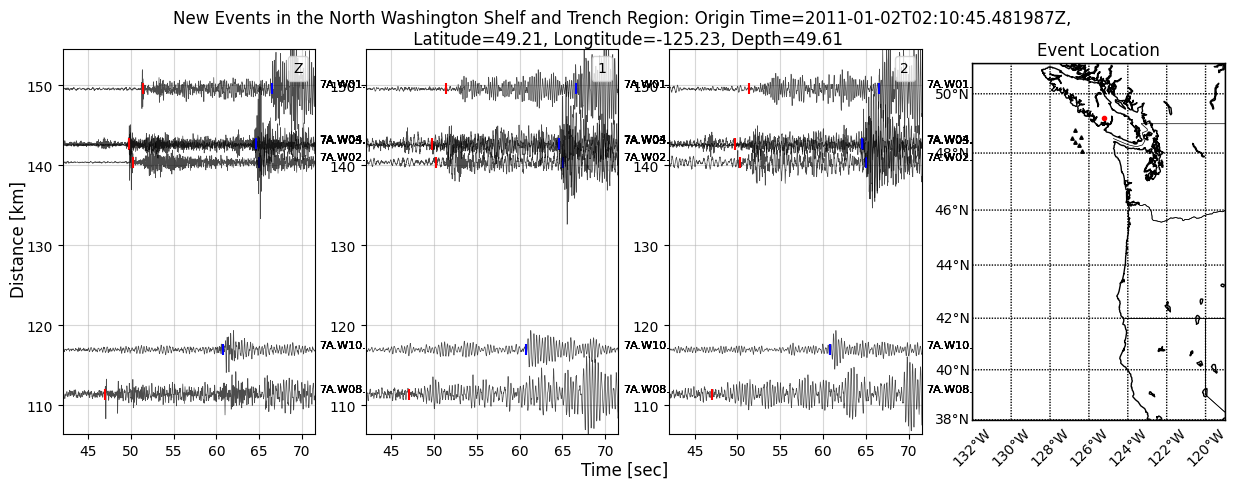

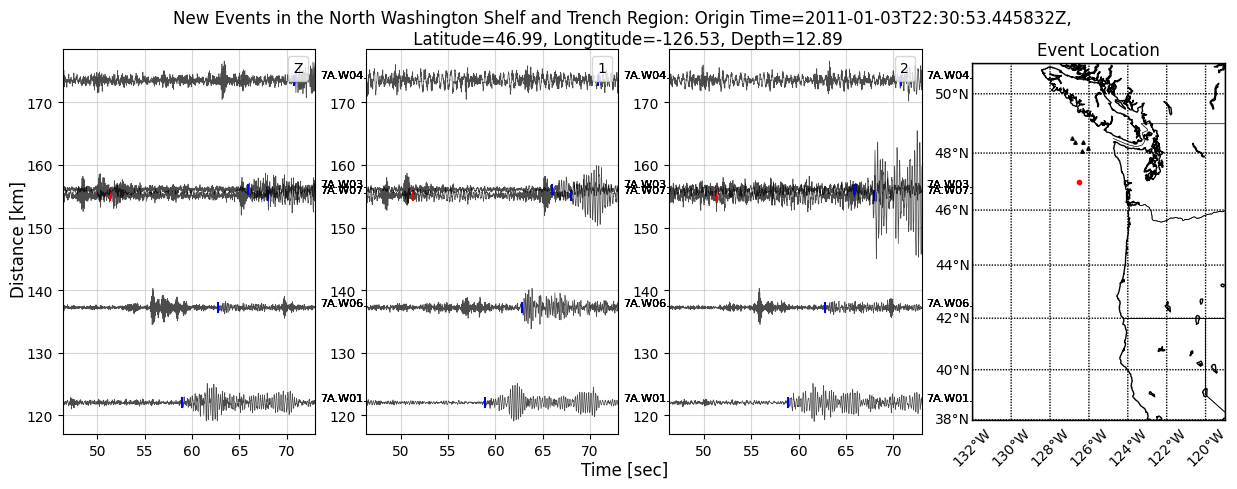

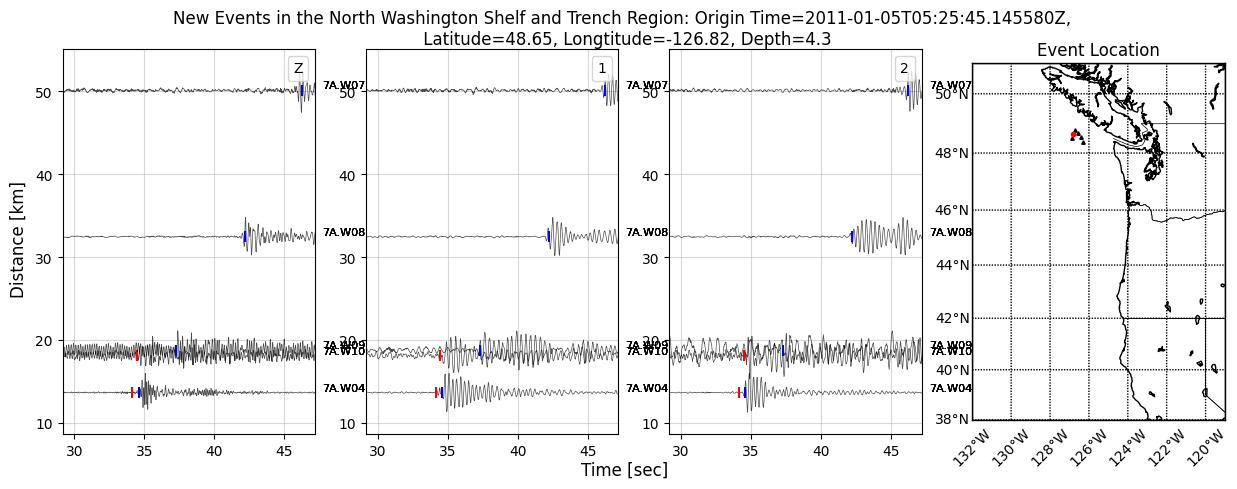

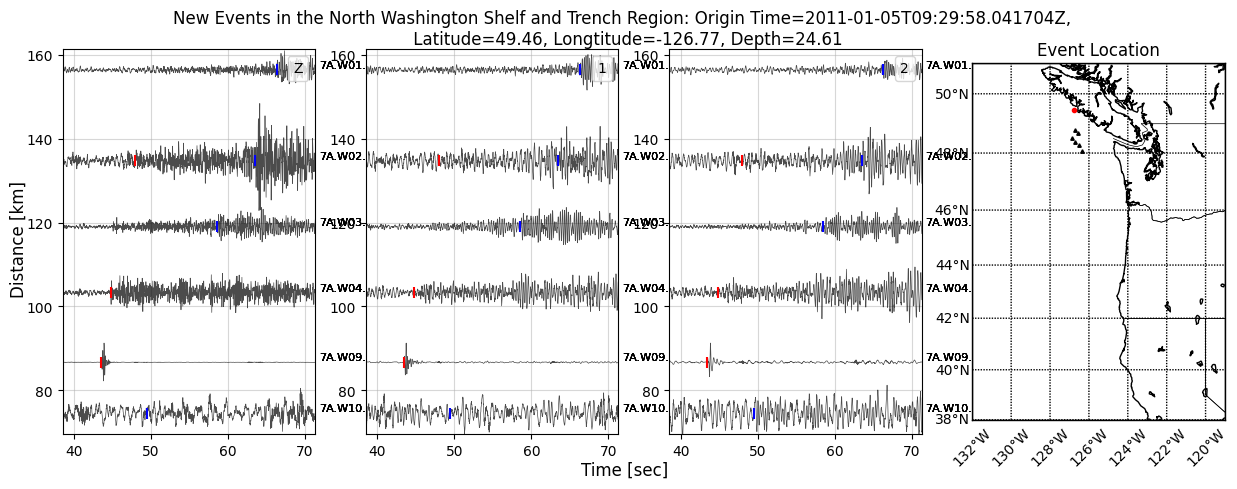

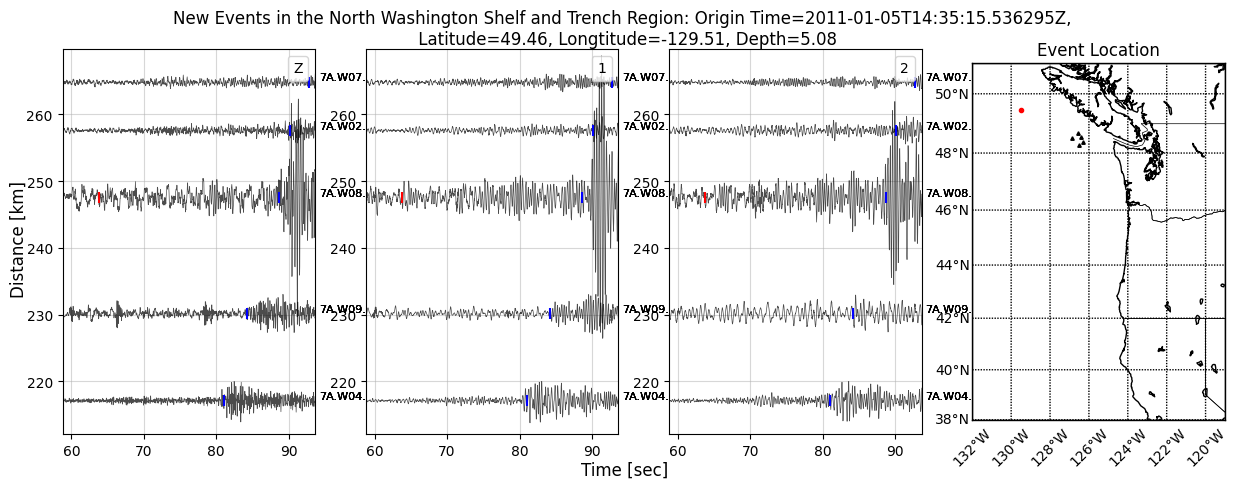

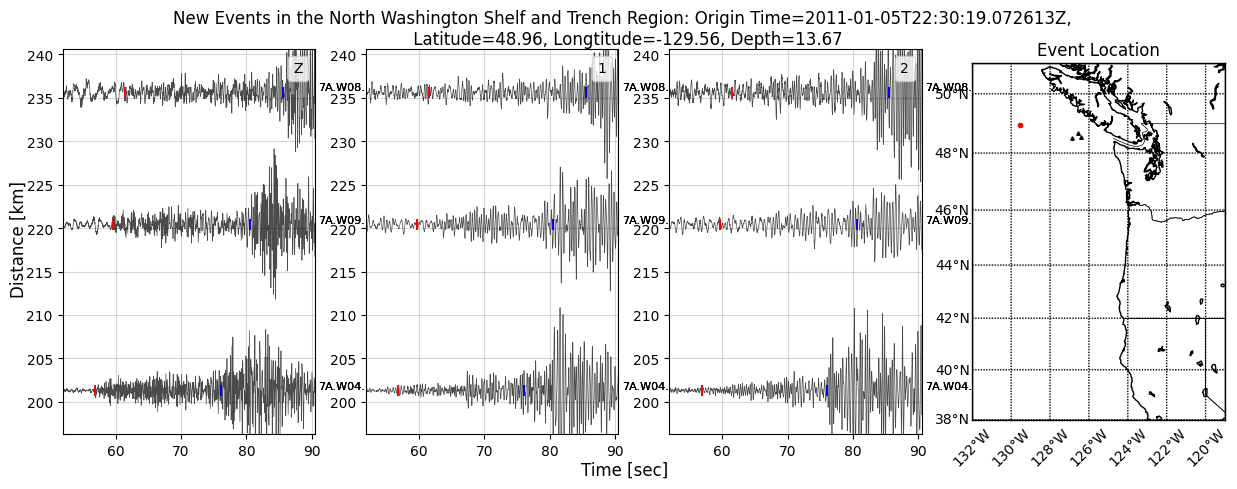

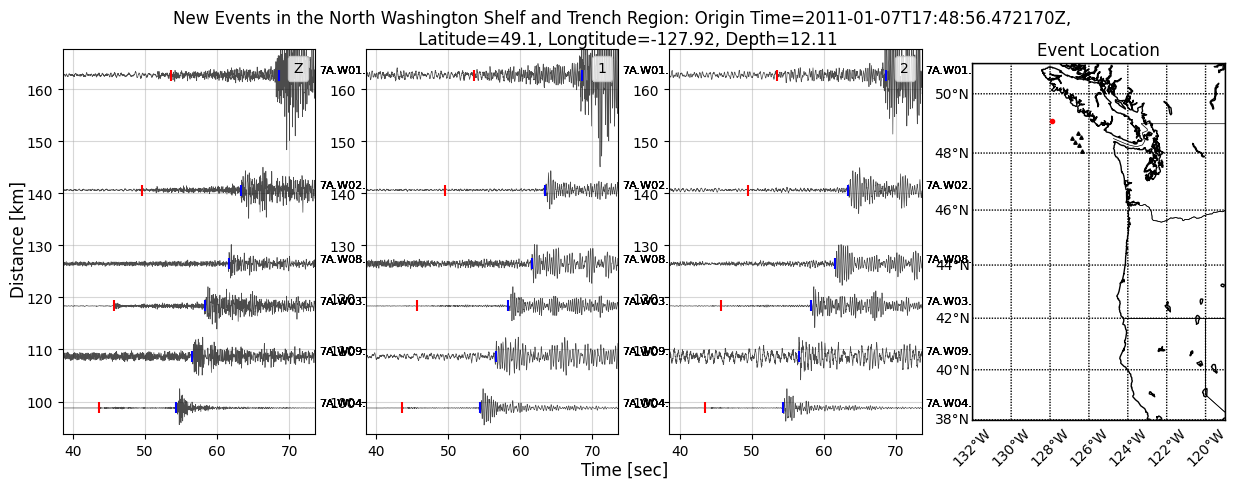

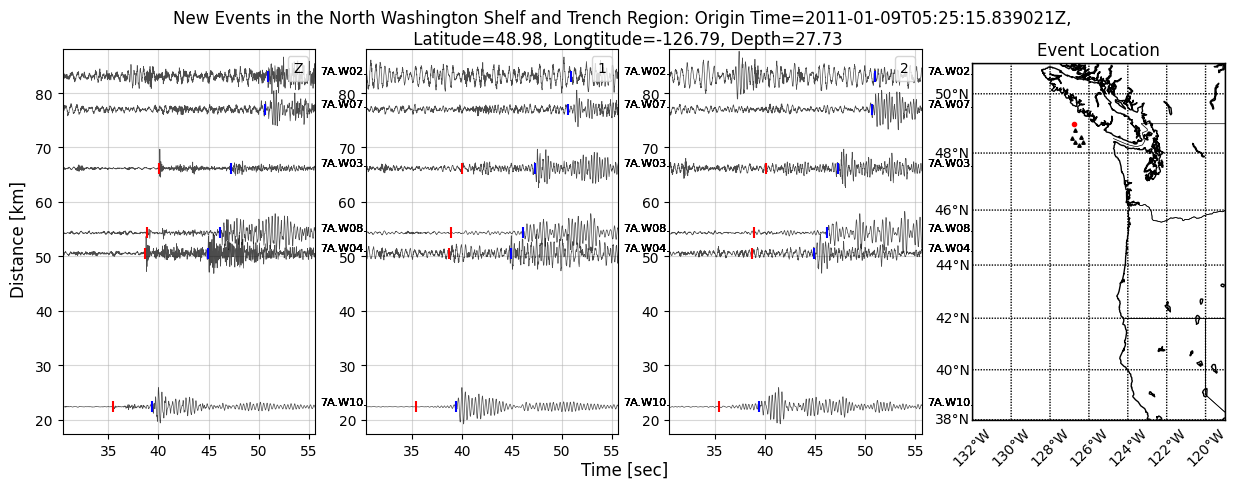

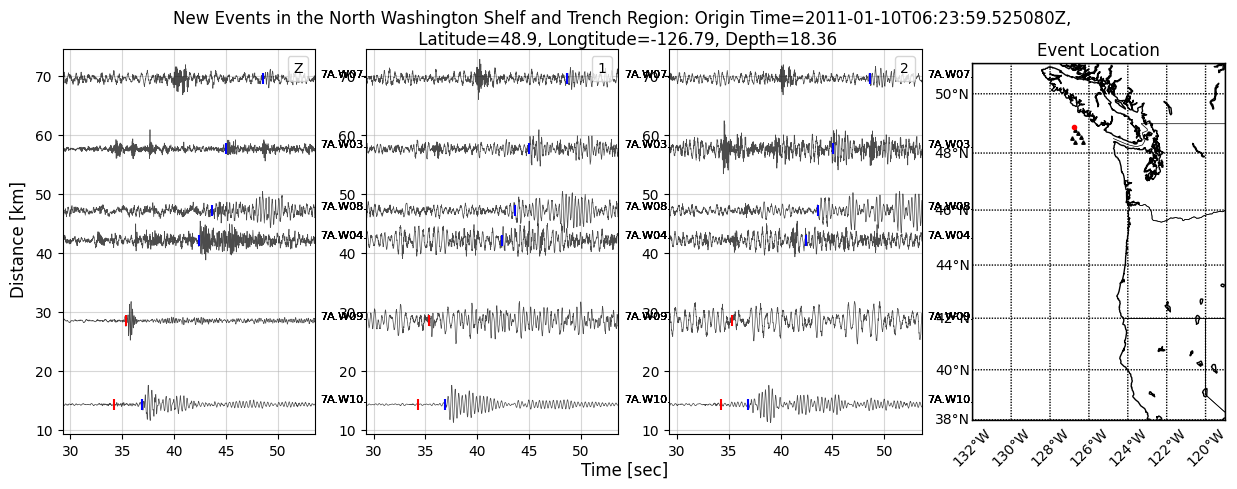

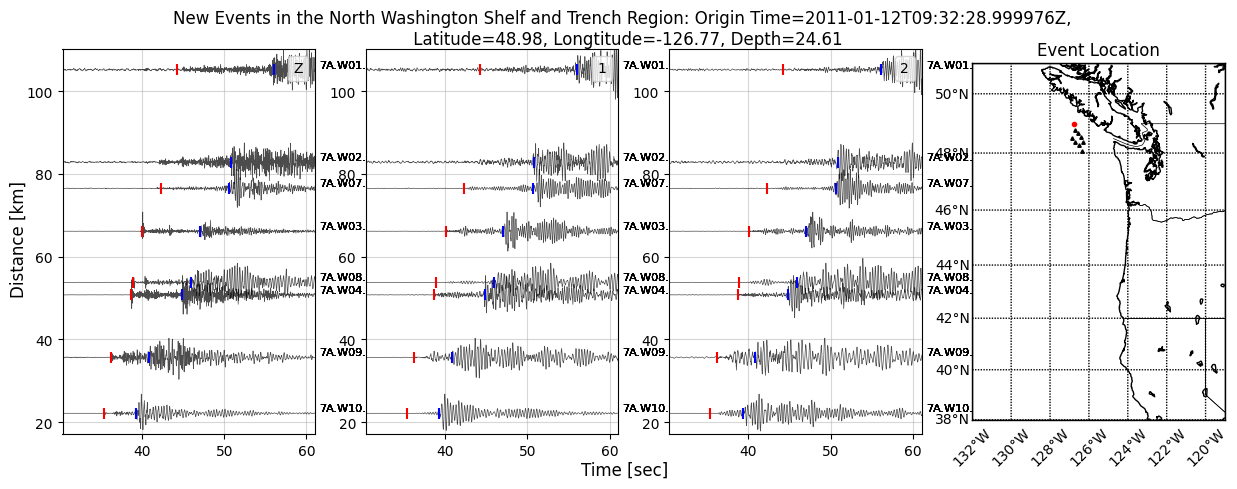

In [86]:
subplot_waveforms(picks_selected,dir,fig_title)
